In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

2023-06-14 15:13:32.761396: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 15:13:32.810595: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 15:13:32.811267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 15:13:33.914501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/matwey/sci/hse/venv/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split = ['train[:75%]', 'train[75%:]']
ds_train, ds_test = tfds.load('cats_vs_dogs', split=split, shuffle_files=True)

In [3]:
resized_ds = ds_test.map(lambda x: (tf.image.resize(x["image"], [224, 224]), x["label"]))

2023-06-14 15:13:35.820085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-06-14 15:13:35.820726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]


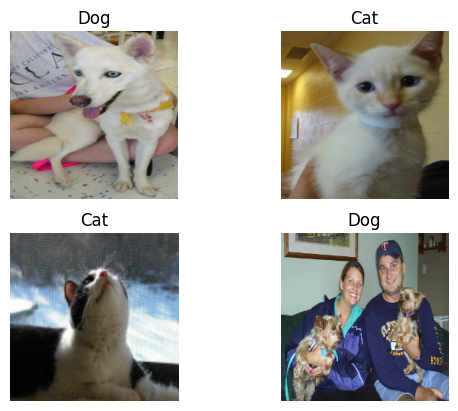

In [4]:
samples = tfds.as_numpy(resized_ds.take(4))

fig, axs = plt.subplots(2, 2)
for i, s in enumerate(samples):
    ax = axs[i // 2, i % 2]
    ax.imshow(s[0].astype(np.uint8))
    ax.axis('Off')
    ax.set_title("{}".format("Dog" if s[1] else "Cat"))

In [5]:
processed_train = ds_train.map(lambda x: (
    tf.keras.applications.resnet.preprocess_input(tf.image.resize(x["image"], [224, 224])),
    x["label"]
    )).batch(64)
processed_test = ds_test.map(lambda x: (
    tf.keras.applications.resnet.preprocess_input(tf.image.resize(x["image"], [224, 224])),
    x["label"]
    )).batch(64)

## Наивная модель

In [6]:
INPUT_SHAPE = (224, 224, 3)
HIDDEN1_CH = 16
HIDDEN2_CH = 32
HIDDEN3_CH = 64
HIDDEN4_CH = 128
HIDDEN5_CH = 128
OUTPUT_DIM = 1

inputs = tf.keras.Input(shape=INPUT_SHAPE, name='input')
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(HIDDEN1_CH, (7, 7), strides=(2, 2), activation="relu"),
    tf.keras.layers.Conv2D(HIDDEN2_CH, (7, 7), strides=(2, 2), activation="relu"),
    tf.keras.layers.Conv2D(HIDDEN3_CH, (7, 7), strides=(2, 2), activation="relu"),
    tf.keras.layers.Conv2D(HIDDEN4_CH, (7, 7), strides=(2, 2), activation="relu"),
    tf.keras.layers.Conv2D(HIDDEN5_CH, (9, 9), strides=(2, 2), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUTPUT_DIM, activation="sigmoid"),
])
outputs = cnn(inputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 109, 109, 16)      2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 52, 52, 32)        25120     
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        100416    
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         401536    
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 128)         1327232   
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [7]:
learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy', metrics=['accuracy'])

fit = model.fit(processed_train, epochs=5, validation_data=processed_test)

Epoch 1/5


2023-06-14 15:13:36.507980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [6]
	 [[{{node Placeholder/_4}}]]
2023-06-14 15:13:36.508851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [6]
	 [[{{node Placeholder/_4}}]]


 82/273 [========>.....................] - ETA: 4:16 - loss: 0.8796 - accuracy: 0.5488

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 99/273 [=========>....................] - ETA: 3:52 - loss: 0.8402 - accuracy: 0.5611

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


136/273 [=============>................] - ETA: 3:02 - loss: 0.7872 - accuracy: 0.5766

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


240/273 [=========================>....] - ETA: 43s - loss: 0.7150 - accuracy: 0.6093

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


244/273 [=========================>....] - ETA: 38s - loss: 0.7135 - accuracy: 0.6100

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


251/273 [==========================>...] - ETA: 29s - loss: 0.7108 - accuracy: 0.6115

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


265/273 [============================>.] - ETA: 10s - loss: 0.7054 - accuracy: 0.6136

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


268/273 [============================>.] - ETA: 6s - loss: 0.7045 - accuracy: 0.6140

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.6155

2023-06-14 15:19:40.833401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
2023-06-14 15:19:40.833968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [2]
	 [[{{node Placeholder/_4}}]]
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 394s 1s/step - loss: 0.7025 - accuracy: 0.6155 - val_loss: 0.5962 - val_accuracy: 0.6769
Epoch 2/5
 82/273 [========>.....................] - ETA: 4:12 - loss: 0.5821 - accuracy: 0.6934

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


100/273 [=========>....................] - ETA: 3:50 - loss: 0.5794 - accuracy: 0.6958

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


135/273 [=============>................] - ETA: 3:03 - loss: 0.5768 - accuracy: 0.6986

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


239/273 [=========================>....] - ETA: 45s - loss: 0.5569 - accuracy: 0.7151

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


245/273 [=========================>....] - ETA: 37s - loss: 0.5562 - accuracy: 0.7158

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


250/273 [==========================>...] - ETA: 30s - loss: 0.5546 - accuracy: 0.7174

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


264/273 [============================>.] - ETA: 11s - loss: 0.5528 - accuracy: 0.7181

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


267/273 [============================>.] - ETA: 7s - loss: 0.5528 - accuracy: 0.7182

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.7191

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 391s 1s/step - loss: 0.5517 - accuracy: 0.7191 - val_loss: 0.5666 - val_accuracy: 0.7099
Epoch 3/5
 81/273 [=======>......................] - ETA: 4:13 - loss: 0.4859 - accuracy: 0.7691

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


100/273 [=========>....................] - ETA: 3:47 - loss: 0.4841 - accuracy: 0.7683

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


136/273 [=============>................] - ETA: 3:00 - loss: 0.4837 - accuracy: 0.7687

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


240/273 [=========================>....] - ETA: 43s - loss: 0.4555 - accuracy: 0.7872

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


245/273 [=========================>....] - ETA: 36s - loss: 0.4552 - accuracy: 0.7879

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


250/273 [==========================>...] - ETA: 30s - loss: 0.4535 - accuracy: 0.7887

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


264/273 [============================>.] - ETA: 11s - loss: 0.4500 - accuracy: 0.7900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


267/273 [============================>.] - ETA: 7s - loss: 0.4499 - accuracy: 0.7900

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.7906

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 389s 1s/step - loss: 0.4491 - accuracy: 0.7906 - val_loss: 0.6058 - val_accuracy: 0.6836
Epoch 4/5
 81/273 [=======>......................] - ETA: 4:13 - loss: 0.3774 - accuracy: 0.8320

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


100/273 [=========>....................] - ETA: 3:48 - loss: 0.3733 - accuracy: 0.8341

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


136/273 [=============>................] - ETA: 3:00 - loss: 0.3708 - accuracy: 0.8352

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


239/273 [=========================>....] - ETA: 44s - loss: 0.3375 - accuracy: 0.8562

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


246/273 [==========================>...] - ETA: 35s - loss: 0.3356 - accuracy: 0.8571

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


251/273 [==========================>...] - ETA: 29s - loss: 0.3336 - accuracy: 0.8583

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


264/273 [============================>.] - ETA: 11s - loss: 0.3297 - accuracy: 0.8605

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


267/273 [============================>.] - ETA: 7s - loss: 0.3292 - accuracy: 0.8605

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8605

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 391s 1s/step - loss: 0.3290 - accuracy: 0.8605 - val_loss: 0.5934 - val_accuracy: 0.7178
Epoch 5/5
 81/273 [=======>......................] - ETA: 4:25 - loss: 0.2661 - accuracy: 0.8993

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 99/273 [=========>....................] - ETA: 4:00 - loss: 0.2575 - accuracy: 0.9040

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


135/273 [=============>................] - ETA: 3:09 - loss: 0.2581 - accuracy: 0.9024

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


239/273 [=========================>....] - ETA: 47s - loss: 0.2520 - accuracy: 0.9034

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


244/273 [=========================>....] - ETA: 40s - loss: 0.2526 - accuracy: 0.9025

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


251/273 [==========================>...] - ETA: 30s - loss: 0.2533 - accuracy: 0.9020

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


264/273 [============================>.] - ETA: 12s - loss: 0.2538 - accuracy: 0.9018

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


267/273 [============================>.] - ETA: 8s - loss: 0.2537 - accuracy: 0.9019

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.9019

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 408s 1s/step - loss: 0.2532 - accuracy: 0.9019 - val_loss: 0.6453 - val_accuracy: 0.7235


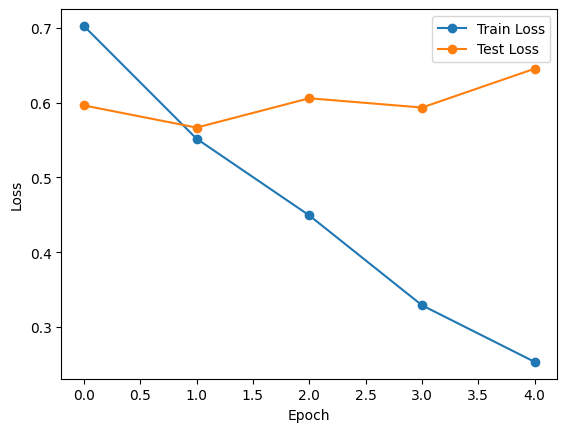

In [8]:
plt.plot(fit.history['loss'], '-o', label="Train Loss")
plt.plot(fit.history['val_loss'], '-o', label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

## Перенос обучения

In [9]:
# Create base model
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
# Freeze base model
base_model.trainable = False

HIDDEN_DIM = 128
OUTPUT_DIM = 1

new_top = tf.keras.Sequential(layers = [
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(HIDDEN_DIM, activation="sigmoid"),
    tf.keras.layers.Dense(OUTPUT_DIM, activation="sigmoid"),
], name="new_top")

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
outputs = new_top(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 new_top (Sequential)        (None, 1)                 262401    
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [10]:
learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy', metrics=['accuracy'])

fit = model.fit(processed_train, epochs=5, validation_data=processed_test)

Epoch 1/5
 82/273 [========>.....................] - ETA: 14:38 - loss: 0.2973 - accuracy: 0.9259

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


100/273 [=========>....................] - ETA: 13:22 - loss: 0.2642 - accuracy: 0.9359

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


136/273 [=============>................] - ETA: 10:32 - loss: 0.2215 - accuracy: 0.9467

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


240/273 [=========================>....] - ETA: 2:31 - loss: 0.1573 - accuracy: 0.9628

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


245/273 [=========================>....] - ETA: 2:08 - loss: 0.1553 - accuracy: 0.9633

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


250/273 [==========================>...] - ETA: 1:45 - loss: 0.1534 - accuracy: 0.9638

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


264/273 [============================>.] - ETA: 41s - loss: 0.1480 - accuracy: 0.9653

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


267/273 [============================>.] - ETA: 27s - loss: 0.1470 - accuracy: 0.9656

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9661

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 1660s 6s/step - loss: 0.1449 - accuracy: 0.9661 - val_loss: 0.0548 - val_accuracy: 0.9871
Epoch 2/5
 82/273 [========>.....................] - ETA: 14:17 - loss: 0.0485 - accuracy: 0.9891

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 99/273 [=========>....................] - ETA: 13:07 - loss: 0.0475 - accuracy: 0.9897

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


136/273 [=============>................] - ETA: 10:22 - loss: 0.0487 - accuracy: 0.9878

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


240/273 [=========================>....] - ETA: 2:29 - loss: 0.0460 - accuracy: 0.9878

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


245/273 [=========================>....] - ETA: 2:06 - loss: 0.0457 - accuracy: 0.9878

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


251/273 [==========================>...] - ETA: 1:39 - loss: 0.0455 - accuracy: 0.9879

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


265/273 [============================>.] - ETA: 36s - loss: 0.0448 - accuracy: 0.9883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


268/273 [============================>.] - ETA: 22s - loss: 0.0447 - accuracy: 0.9882

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9884

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 1655s 6s/step - loss: 0.0444 - accuracy: 0.9884 - val_loss: 0.0382 - val_accuracy: 0.9890
Epoch 3/5
 82/273 [========>.....................] - ETA: 14:44 - loss: 0.0332 - accuracy: 0.9924

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


100/273 [=========>....................] - ETA: 13:24 - loss: 0.0330 - accuracy: 0.9927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


135/273 [=============>................] - ETA: 10:36 - loss: 0.0355 - accuracy: 0.9909

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


240/273 [=========================>....] - ETA: 2:30 - loss: 0.0346 - accuracy: 0.9902

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


245/273 [=========================>....] - ETA: 2:07 - loss: 0.0345 - accuracy: 0.9902

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


251/273 [==========================>...] - ETA: 1:40 - loss: 0.0343 - accuracy: 0.9903

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


265/273 [============================>.] - ETA: 36s - loss: 0.0338 - accuracy: 0.9906

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


268/273 [============================>.] - ETA: 22s - loss: 0.0338 - accuracy: 0.9906

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 1647s 6s/step - loss: 0.0335 - accuracy: 0.9907 - val_loss: 0.0327 - val_accuracy: 0.9905
Epoch 4/5
 82/273 [========>.....................] - ETA: 14:40 - loss: 0.0269 - accuracy: 0.9935

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


100/273 [=========>....................] - ETA: 13:18 - loss: 0.0270 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


136/273 [=============>................] - ETA: 10:36 - loss: 0.0298 - accuracy: 0.9922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


240/273 [=========================>....] - ETA: 2:33 - loss: 0.0292 - accuracy: 0.9917

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


245/273 [=========================>....] - ETA: 10:13 - loss: 0.0290 - accuracy: 0.9918

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


251/273 [==========================>...] - ETA: 7:53 - loss: 0.0289 - accuracy: 0.9918

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


264/273 [============================>.] - ETA: 3:06 - loss: 0.0285 - accuracy: 0.9920

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


267/273 [============================>.] - ETA: 2:02 - loss: 0.0285 - accuracy: 0.9919

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9921 

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 5885s 22s/step - loss: 0.0282 - accuracy: 0.9921 - val_loss: 0.0301 - val_accuracy: 0.9907
Epoch 5/5
 83/273 [========>.....................] - ETA: 14:05 - loss: 0.0229 - accuracy: 0.9940

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


100/273 [=========>....................] - ETA: 12:49 - loss: 0.0241 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


136/273 [=============>................] - ETA: 10:10 - loss: 0.0261 - accuracy: 0.9928

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/273 [=========================>....] - ETA: 2:36 - loss: 0.0258 - accuracy: 0.9924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


245/273 [=========================>....] - ETA: 2:04 - loss: 0.0255 - accuracy: 0.9925

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


250/273 [==========================>...] - ETA: 1:42 - loss: 0.0256 - accuracy: 0.9924

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


264/273 [============================>.] - ETA: 40s - loss: 0.0250 - accuracy: 0.9927

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


267/273 [============================>.] - ETA: 26s - loss: 0.0251 - accuracy: 0.9926

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/273 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9928

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 1621s 6s/step - loss: 0.0248 - accuracy: 0.9928 - val_loss: 0.0286 - val_accuracy: 0.9912


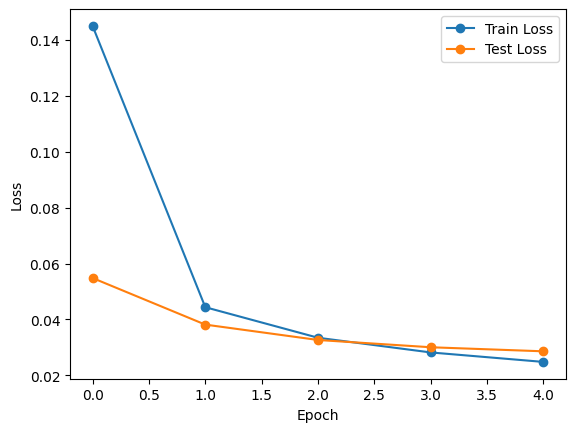

In [11]:
plt.plot(fit.history['loss'], '-o', label="Train Loss")
plt.plot(fit.history['val_loss'], '-o', label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

2023-06-14 19:14:24.498362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-06-14 19:14:24.499238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]


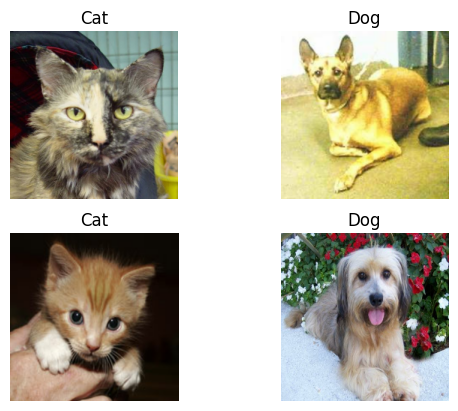

In [12]:
samples = tfds.as_numpy(resized_ds.take(4))

fig, axs = plt.subplots(2, 2)
for i, s in enumerate(samples):
    d = tf.expand_dims(tf.keras.applications.resnet.preprocess_input(tf.image.resize(s[0], [224, 224])), 0)
    p = model.predict(d, verbose=False)[0,0]
    ax = axs[i // 2, i % 2]
    ax.imshow(s[0].astype(np.uint8))
    ax.axis('Off')
    ax.set_title("{}".format("Dog" if p > 0.5 else "Cat"))

In [13]:
import sklearn.metrics

scores = []
labels = []
for x in processed_test.take(-1):
    scores.append(model.predict(x[0], verbose=False))
    labels.append(x[1].numpy())

scores = np.concatenate(scores)
labels = np.concatenate(labels)

fpr, tpr, _ = sklearn.metrics.roc_curve(labels, scores)
roc = {"tpr": tpr, "fpr": fpr}
auc = sklearn.metrics.roc_auc_score(labels, scores)

2023-06-14 19:14:27.157127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2]
	 [[{{node Placeholder/_1}}]]
2023-06-14 19:14:27.158407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


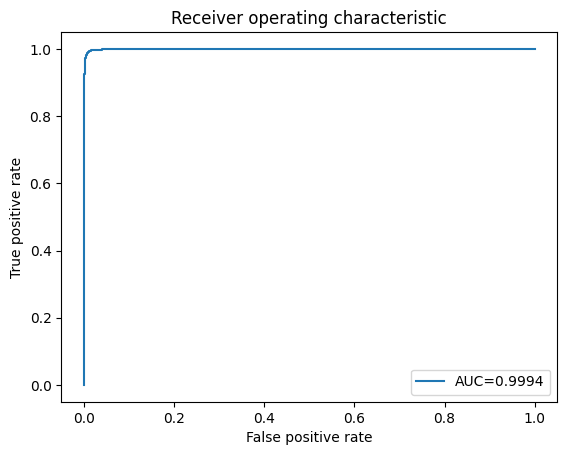

In [14]:
plt.figure()
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(roc['fpr'], roc['tpr'], label='AUC={:.4f}'.format(auc))
_ = plt.legend(loc='lower right')